In [16]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

/Users/raficg/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def get_all():
    fpath = '../congress-data/members/'
    files = os.listdir(fpath)
    house = set()
    senate = set()
    dem = set()
    rep = set()
    men = set()
    women = set()
    leaders = set()
    
    for file in files:
        df = pd.read_csv(fpath+file, index_col=0)
        mem_id = df.loc[0]['id']
        
        if df.loc[0]['gender'] == 'F':
            women.add(mem_id)
        else:
            men.add(mem_id)
            
        if len(df['chamber'].unique()) > 1:
            house.add(mem_id)
            senate.add(mem_id)
        elif df.loc[0]['chamber'].lower() == 'house':
            house.add(mem_id)
        else:
            senate.add(mem_id)
            
        if len(df['party'].unique()) > 1:
            rep.add(mem_id)
            dem.add(mem_id)
        elif df.loc[0]['party'] == 'D':
            dem.add(mem_id)
        else:
            rep.add(mem_id)
            
        for role in df['leadership_role']:
            if type(role) == str:
                leaders.add(df.loc[0]['id'])
                continue

    return house, senate, dem, rep, men, women, leaders

def get_ids(chamber, start_con, end_con, party=None):
    fpath = '../congress-data/members/'
    files = os.listdir(fpath)
    id_set = set()
    for file in files:
        df = pd.read_csv(fpath+file, index_col=0)
        
        sessions = df['congress'].values
        
        first_con = min(sessions)
        last_con = max(sessions)
        
        if first_con > end_con or last_con < start_con:
            continue
            
        if party != None:
            if (len(df['party'].unique()) > 1) or (df.loc[0]['party'] == party):
                id_set.add(df.loc[0]['id'])
                continue
        
        if (len(df['chamber'].unique()) > 1) or (df.loc[0]['chamber'].lower() == chamber):
            id_set.add(df.loc[0]['id'])
                
    return id_set

def get_csv(mem_id):
    fpath = '../congress-data/members/'
    df = pd.read_csv(fpath+mem_id+'.csv', index_col=0)
    
    df.dropna(subset=['gender', 'total_votes', 
                  'missed_votes', 'bills_sponsored',
                  'bills_cosponsored'], inplace=True)
    return df

In [3]:
(house, senate, dem, rep, men, women, leaders) = get_all()

### Basic Stats

In [19]:
def missed_votes_5_num_sum(group_1, group_2, grouping, g1_filter, g2_filter):
    g1_missed_votes = []
    
    g2_missed_votes = []
    
    for mem_id in group_1:
        df = get_csv(mem_id)
        if len(df) == 0:
            continue
        
        df = df[df[grouping] == g1_filter]
        g1_missed_votes.extend(df['missed_votes'])
        
    for mem_id in group_2:
        df = get_csv(mem_id)
        if len(df) == 0:
            continue
        
        df = df[df[grouping] == g2_filter]
        g2_missed_votes.extend(df['missed_votes'])
        
    g1_quartiles = np.percentile(g1_missed_votes, [25, 50, 75])
    g2_quartiles = np.percentile(g2_missed_votes, [25, 50, 75])
    
    g1_min = np.min(g1_missed_votes)
    g1_max = np.max(g1_missed_votes)
    
    g2_min = np.min(g2_missed_votes)
    g2_max = np.max(g2_missed_votes)
    
    
    print('Comparing: %s' % (grouping))
    print('    | %s | %s |' % (g1_filter, g2_filter))
    print('Min:| %d | %d |' % (g1_min, g2_min))
    print('Q1: | %d | %d |' % (g1_quartiles[0], g2_quartiles[0]))
    print('Med:| %d | %d |' % (g1_quartiles[1], g2_quartiles[1]))
    print('Q3: | %d | %d |' % (g1_quartiles[2], g2_quartiles[2]))
    print('Max:| %d | %d |' % (g1_max, g2_max))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    sns.boxenplot(g1_missed_votes, ax=ax[0], orient='v')
    sns.boxenplot(g2_missed_votes, ax=ax[1], orient='v')


    #ax[0].boxplot(g1_missed_votes)
    #ax[1].boxplot(g2_missed_votes)
    ax[0].set_title('%s Missed Votes' % g1_filter)
    ax[1].set_title('%s Missed Votes' % g2_filter)
        

Comparing: party
    | D | R |
Min:| 0 | 0 |
Q1: | 13 | 12 |
Med:| 32 | 26 |
Q3: | 66 | 52 |
Max:| 1695 | 1594 |


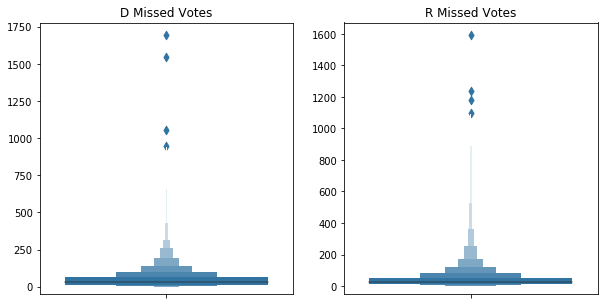

In [20]:
missed_votes_5_num_sum(dem, rep, 'party', 'D', 'R')

We see that Democrats tend to have a slightly higher amount of missed votes than Republicans:

```
Comparing: party
    | D    | R    |
----+------+------+
Min:| 0    | 0    |
Q1: | 13   | 12   |
Med:| 32   | 26   |
Q3: | 66   | 52   |
Max:| 1695 | 1594 |
```

Comparing: gender
    | M | F |
Min:| 0 | 0 |
Q1: | 12 | 11 |
Med:| 28 | 32 |
Q3: | 58 | 65 |
Max:| 1594 | 1695 |


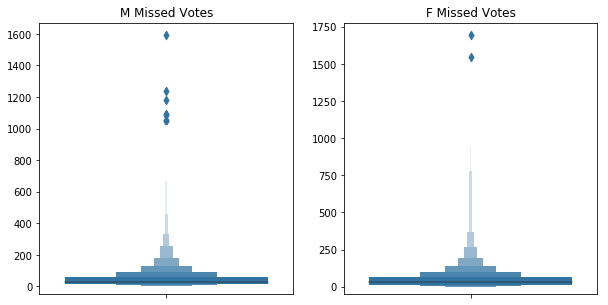

In [21]:
missed_votes_5_num_sum(men, women, 'gender', 'M', 'F')


We see that women tend to have a slightly higher amount of missed votes than men:
```
Comparing: gender
    | M    | F    |
----+------+------+
Min:| 0    | 0    |
Q1: | 12   | 11   |
Med:| 28   | 32   |
Q3: | 58   | 65   |
Max:| 1594 | 1695 |
```

Comparing: chamber
    | House | Senate |
Min:| 0 | 0 |
Q1: | 16 | 4 |
Med:| 34 | 10 |
Q3: | 66 | 22 |
Max:| 1695 | 488 |


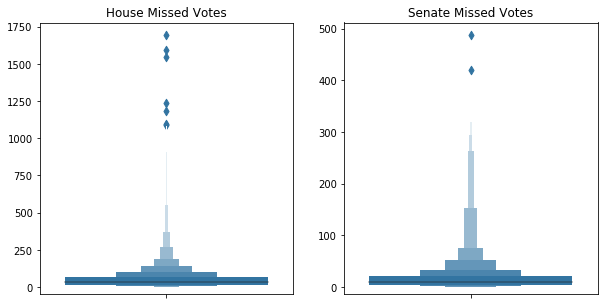

In [22]:
missed_votes_5_num_sum(house, senate, 'chamber', 'House', 'Senate')

We see that representatives tend to have a slightly higher amount of missed votes than senators. It is worth noting, however, that there are far more roll-call votes in the House than the Senate:
```
Comparing: chamber
    | House | Senate |
----+-------+--------+
Min:| 0     | 0      |
Q1: | 16    | 4      |
Med:| 34    | 10     |
Q3: | 66    | 22     |
Max:| 1695  | 488    |
```

In [32]:
house_leaders = leaders.intersection(house)
senate_leaders = leaders.intersection(senate)

In [36]:
house_non_leaders = house - house_leaders
senate_non_leaders = senate - senate_leaders

Comparing: chamber
    | House | House |
Min:| 0 | 0 |
Q1: | 16 | 21 |
Med:| 34 | 35 |
Q3: | 66 | 62 |
Max:| 1594 | 1695 |


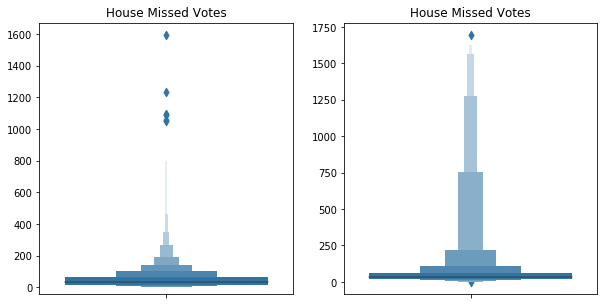

In [38]:
missed_votes_5_num_sum(house_non_leaders, house_leaders, 'chamber', 'House', 'House')

Comparing: chamber
    | House | House |
Min:| 0 | 2 |
Q1: | 17 | 27 |
Med:| 30 | 35 |
Q3: | 50 | 79 |
Max:| 307 | 252 |


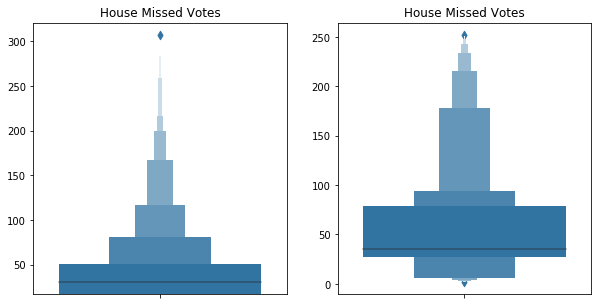

In [39]:
missed_votes_5_num_sum(senate_non_leaders, senate_leaders, 'chamber', 'House', 'House')

### Plotting leaders' total missed votes over time

In [51]:
def plot_leaders(leader_ids):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for leader_id in leader_ids:
        df = get_csv(leader_id)
        
        missed_votes = df['missed_votes']
        congress = df['congress']
        
        ax.plot(congress, missed_votes)

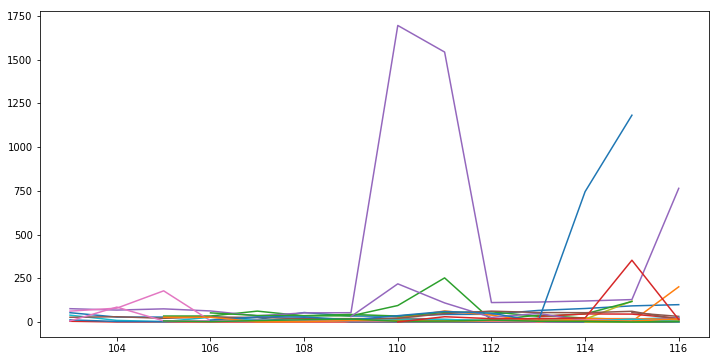

In [52]:
plot_leaders(leaders)

In [42]:
df = get_csv('D000563')

In [50]:
df[~df['leadership_role'].isnull()]

,id,first_name,last_name,dob,gender,current_party,govtrack_id,cspan_id,congress,chamber,...,total_votes,missed_votes,total_present,bills_sponsored,bills_cosponsored,votes_with_party_pct,votes_against_party_pctcommittees,subcommittees,committees,votes_against_party_pct
0,D000563,Richard,Durbin,1944-11-21,M,D,300038,6741,116,Senate,...,557.0,9.0,1.0,93.0,551.0,95.65,NaN,13,4.0,4.35
1,D000563,Richard,Durbin,1944-11-21,M,D,300038,6741,115,Senate,...,599.0,15.0,1.0,60.0,484.0,94.43,NaN,10,3.0,5.57


In [58]:
roles = set()
for ids in leaders:
    df = get_csv(ids)
    df = df[~df['leadership_role'].isnull()]
    
    roles.update(df['leadership_role'].values)
    
roles

{'Assistant Leader',
 'Assistant Senate Majority Leader',
 'Assistant Senate Minority Leader',
 'Caucus Chair',
 'Conference Chair',
 'House Democratic Caucus Chair',
 'House Majority Leader',
 'House Majority Whip',
 'House Minority Leader',
 'House Minority Whip',
 'House Republican Conference Chair',
 'House Republican Policy Committee Chair',
 'Majority Leader',
 'Majority Whip',
 'Minority Leader',
 'Minority Whip',
 'Policy Committee Chair',
 'President Pro Tempore of the Senate',
 'Senate Democratic Policy & Communications Committee Chair',
 'Senate Democratic Steering Committee Chair',
 'Senate Majority Leader',
 'Senate Majority Whip',
 'Senate Minority Leader',
 'Senate Minority Whip',
 'Senate Republican Conference Chair',
 'Senate Republican Conference Vice Chair',
 'Senate Republican Policy Committee Chair',
 'Speaker of the House'}